<a href="https://colab.research.google.com/github/glamacles/downs_project/blob/main/intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Firedrake Install

In [1]:
import os
arch = os.getenv("ARGS", "real")

try:
    import google.colab  # noqa: F401
except ImportError:
    import firedrake as fd
else:
    try:
        import firedrake as fd
    except ImportError:
        if arch != "complex":
            !wget "https://fem-on-colab.github.io/releases/firedrake-install-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
        else:
            !wget "https://fem-on-colab.github.io/releases/firedrake-install-complex.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
        import firedrake as fd

!pip install nvidia-modulus nvidia-modulus-sym

--2024-06-07 18:31:00--  https://fem-on-colab.github.io/releases/firedrake-install-real.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.110.153, 185.199.111.153, 185.199.108.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.110.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4581 (4.5K) [application/x-sh]
Saving to: ‘/tmp/firedrake-install.sh’

/tmp/firedrake-inst 100%[===================>]   4.47K  --.-KB/s    in 0s      

2024-06-07 18:31:00 (46.5 MB/s) - ‘/tmp/firedrake-install.sh’ saved [4581/4581]

+ INSTALL_PREFIX=/usr/local
++ echo /usr/local
++ awk -F/ '{print NF-1}'
+ INSTALL_PREFIX_DEPTH=2
+ PROJECT_NAME=fem-on-colab
+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ FIREDRAKE_INSTALLED=/usr/local/share/fem-on-colab/firedrake.installed
+ [[ ! -f /usr/local/share/fem-on-colab/firedrake.installed ]]
+ PYBIND11_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/c990175/rele

# Clone project repo and mount Google Drive

In [1]:
!git clone https://github.com/glamacles/downs_project
from google.colab import drive
drive.mount('/content/drive')

Cloning into 'downs_project'...
remote: Enumerating objects: 53, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 53 (delta 16), reused 42 (delta 12), pack-reused 0
Receiving objects: 100% (53/53), 8.96 MiB | 13.51 MiB/s, done.
Resolving deltas: 100% (16/16), done.
Mounted at /content/drive


In [2]:
cd downs_project

/content/downs_project


# Introduction
- In this project we'll create an emulator to predict ice flow velocity for synthetic ice sheets with bumpy beds
- We'll use a simplified implementation of SpecEIS that uses CG1 elements for all velocity components
- We'll use a uniform mesh to simplify mapping between Firedrake and Pytorch
- And we'll use a Fourier Neural Operator (FNO) as our NN architecture

# Demo

- This demo will show an idea of what we'll create
- Here we load the SpecEIS FEM model as well as a pretrained emulator

In [3]:
import os
import sys
import matplotlib.pyplot as plt
os.environ['OMP_NUM_THREADS'] = '1'
sys.path.append('model/')
sys.path.append('emulator/')
import numpy as np
import firedrake as fd
from model import SpecFO
from emulator import FNOEmulator
import torch

# FEM Model
model = SpecFO()

# FNO Emulator
emulator = FNOEmulator().cuda()
checkpoint = torch.load('emulator/weights.pt')
emulator.load_state_dict(checkpoint)
emulator.eval()

/usr/local/lib/python3.10/dist-packages/firedrake/interpolation.py:385: FutureWarning: The use of `interpolate` to perform the numerical interpolation is deprecated.
This feature will be removed very shortly.

Instead, import `interpolate` from the `firedrake.__future__` module to update
the interpolation's behaviour to return the symbolic `ufl.Interpolate` object associated
with this interpolation.

You can then assemble the resulting object to get the interpolated quantity
of interest. For example,

```
from firedrake.__future__ import interpolate
...

assemble(interpolate(expr, V))
```

Alternatively, you can also perform other symbolic operations on the interpolation operator, such as taking
the derivative, and then assemble the resulting form.

  warnings.warn("""The use of `interpolate` to perform the numerical interpolation is deprecated.
/usr/local/lib/python3.10/dist-packages/firedrake/interpolation.py:385: FutureWarning: The use of `interpolate` to perform the numerical inter

FNOEmulator(
  (fno): FNO(
    (activation_fn): GELU(approximate='none')
    (decoder_net): FullyConnected(
      (layers): ModuleList(
        (0): FCLayer(
          (activation_fn): SiLU()
          (linear): Linear(in_features=32, out_features=32, bias=True)
        )
      )
      (final_layer): FCLayer(
        (activation_fn): Identity()
        (linear): Linear(in_features=32, out_features=4, bias=True)
      )
    )
    (spec_encoder): FNO2DEncoder(
      (activation_fn): GELU(approximate='none')
      (lift_network): Sequential(
        (0): Conv2dFCLayer(
          (activation_fn): Identity()
          (conv): Conv2d(5, 16, kernel_size=(1, 1), stride=(1, 1))
        )
        (1): GELU(approximate='none')
        (2): Conv2dFCLayer(
          (activation_fn): Identity()
          (conv): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1))
        )
      )
      (spconv_layers): ModuleList(
        (0-3): 4 x SpectralConv2d()
      )
      (conv_layers): ModuleList(
        (0

- Now, we'll generate some random ice sheet geometry and estimate velocity using SpecEIS and the FNO emulator
- Hopefully, the FNO predicts velocity pretty accurately

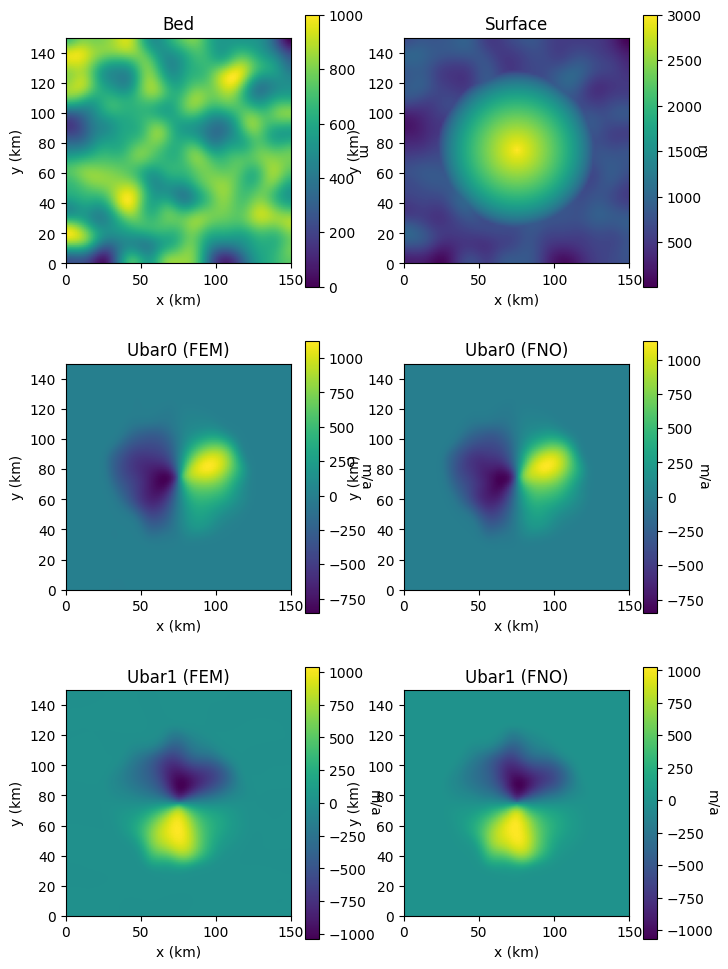

In [9]:

# Generate random ice sheet geometry
B, H = model.get_geometry(
    B0 = 1000.,
    S0 = 3000,
)

# Solve for velocity
model.U.assign(0.*model.U)
model.set_field(model.B, B)
model.set_field(model.H, H)
model.solver.solve()
ubar0, ubar1, udef0, udef1, s0, s1 = model.get_velocity()

with torch.no_grad():
    x = np.stack([
        B, H
    ])[np.newaxis, :, :, :]
    x = torch.tensor(x, dtype=torch.float32).cuda()

    y = emulator(x).cpu()

    extent=[0., model.dx/1e3, 0., model.dy/1e3]

    fig = plt.figure(figsize=(8,12))

    plt.subplot(3,2,1)
    plt.title('Bed')
    plt.imshow(B, extent=extent)
    plt.xlabel('x (km)')
    plt.ylabel('y (km)')
    cbar = plt.colorbar()
    cbar.set_label('m', rotation=270)


    plt.subplot(3,2,2)
    plt.title('Surface')
    plt.imshow(B+H, extent=extent)
    plt.xlabel('x (km)')
    plt.ylabel('y (km)')
    cbar = plt.colorbar()
    cbar.set_label('m', rotation=270)

    plt.subplot(3,2,3)
    plt.title(f'Ubar0 (FEM)')
    plt.imshow(ubar0,  extent=extent)
    plt.xlabel('x (km)')
    plt.ylabel('y (km)')
    cbar = plt.colorbar()
    cbar.set_label('m/a', rotation=270)


    plt.subplot(3,2,4)
    plt.title(f'Ubar0 (FNO)')
    plt.imshow(y[0,0,:,:],  extent=extent)
    plt.xlabel('x (km)')
    plt.ylabel('y (km)')
    cbar = plt.colorbar()
    cbar.set_label('m/a', rotation=270)

    plt.subplot(3,2,5)
    plt.title(f'Ubar1 (FEM)')
    plt.imshow(ubar1,  extent=extent)
    plt.xlabel('x (km)')
    plt.ylabel('y (km)')
    cbar = plt.colorbar()
    cbar.set_label('m/a', rotation=270)

    plt.subplot(3,2,6)
    plt.title(f'Ubar1 (FNO)')
    plt.imshow(y[0,1,:,:],  extent=extent)
    plt.xlabel('x (km)')
    plt.ylabel('y (km)')
    cbar = plt.colorbar()
    cbar.set_label('m/a', rotation=270)

    plt.show()


# Training Data
- For training data we'll use a bunch of randomized synthetic ice sheets
- These are ice caps / ice dome type things (technically speaking, of course)
- Not necessarily physically realistic, but a good starting point for an ice sheet emulator
- Random geometry is generated using the following code:

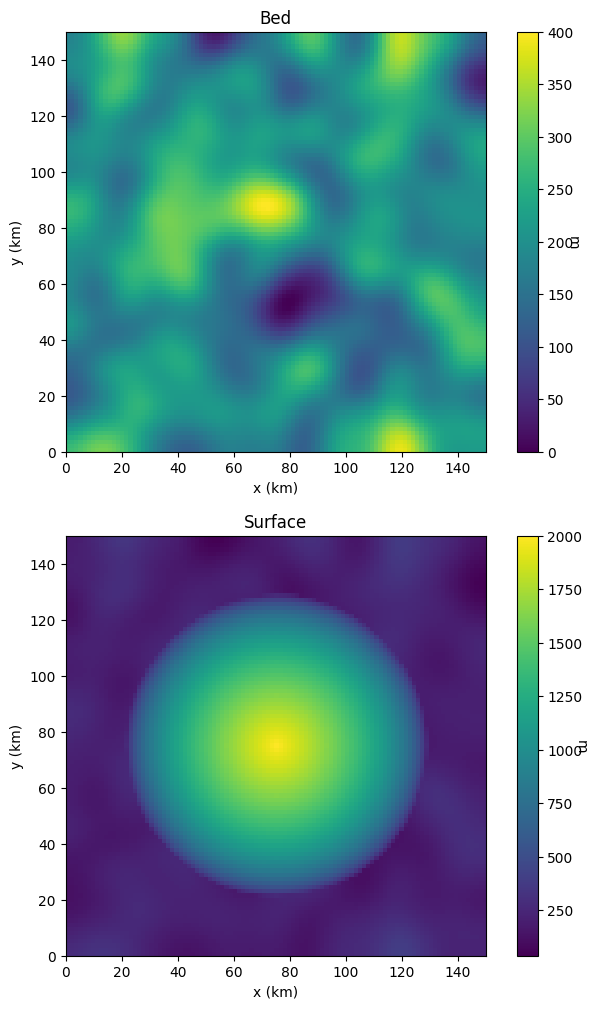

In [8]:
B, H = model.get_geometry(
        S0 = 2000, # Ice sheet peak elevation
        B0 = 400, # Scales height of bed bumps
        sigma = 5., # Length scale (bigger values mean bigger bumps)
        mid_offset = np.array([0.,0.]) # Adjusts the midpoint of our dome
)

fig = plt.figure(figsize=(8,12))
plt.subplot(2,1,1)
plt.title('Bed')
plt.imshow(B, extent=extent)
plt.xlabel('x (km)')
plt.ylabel('y (km)')
cbar = plt.colorbar()
cbar.set_label('m', rotation=270)


plt.subplot(2,1,2)
plt.title('Surface')
plt.imshow(B+H, extent=extent)
plt.xlabel('x (km)')
plt.ylabel('y (km)')
cbar = plt.colorbar()
cbar.set_label('m', rotation=270)

plt.show()

# Prepared Training data

- I will provide a dataset for training that includes 4000 randomly generated ice sheets and their velocity solutions
- Paramters S0, B0, sigma, and mid_offset are also randomized leading to lots of interesting geometries

# To PINN or not to PINN
- In the model, I provide some optional code for computing a PINN loss function based on the variational principle for SpecEIS
- This is analagous to what IGM uses
- If you are stoked on PINNs you can use this loss function
- Caveat: training tends to be kind of slow in this approach
- Hence, using the FEM velocity in your training is probably the best way to start